<a href="https://www.kaggle.com/code/fummicc1/fummicc1-cassava?scriptVersionId=115383373" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# !pip install --upgrade torch torchvision

## Data

In [3]:
import torch
import torch.nn as nn
import pandas as pd
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
from typing import Dict, List, Tuple
from tqdm import tqdm
import pandas as pd

In [4]:
class Config:
    base_input_path = "/kaggle/input/cassava-leaf-disease-classification"
    batch_size = 64
    num_workers = 4
    n_epochs = 30
    lr = 1e-4
    
    def __init__(self):
        pass
    
config = Config()

def convert_num2label(num: int) -> str:
    return {
        "0": "Cassava Bacterial Blight (CBB)",
        "1": "Cassava Brown Streak Disease (CBSD)",
        "2": "Cassava Green Mottle (CGM)",
        "3": "Cassava Mosaic Disease (CMD)",
        "4": "Healthy",
    }[num]


def class2dict(f) -> Dict:
    ans = dict()
    for name in dir(f):
        if name.startswith("__"):
            continue
        if not _is_primitive(getattr(f, name)):
            ans[name] = class2dict(getattr(f, name))
        else:
            ans[name] = getattr(f, name)
    return ans


def _is_primitive(value) -> bool:
    primitive = (int, str, bool, float, List, Dict)
    return type(value) in primitive

<AxesSubplot:>

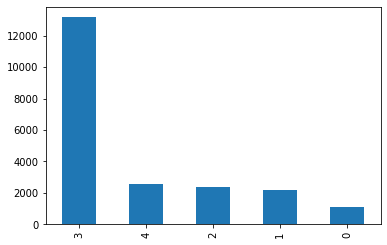

In [5]:
train_path = os.path.join(config.base_input_path, "train.csv")
train_img_dir_path = os.path.join(config.base_input_path, "train_images")
train_df = pd.read_csv(train_path)
train_df.label.value_counts().plot(kind="bar")

In [6]:
class CassavaDataset(Dataset):
    def __init__(self, annotation_path: str, img_dir_path: str, img_transforms: transforms.Compose):
        self.annotation_path = annotation_path
        self.annotation_data = pd.read_csv(annotation_path)
        self.img_dir_path = img_dir_path
        self.img_transforms = img_transforms
        
    def __len__(self) -> int:
        return len(self.annotation_data)
    
    def __getitem__(self, index: int):
        data = self.annotation_data.iloc[index, :]
        image_id = data["image_id"]
        label = data["label"]        
        image_path = os.path.join(self.img_dir_path, image_id)        
        img = Image.open(image_path).convert("RGB")
        if self.img_transforms:
            img = self.img_transforms(img)
        label = torch.nn.functional.one_hot(torch.tensor([label]), num_classes=5)
        label = torch.squeeze(label, dim=0).float()
        return img, image_id, label

## Network

In [7]:
from torchvision.models import resnet18


class CassavaNetwork(nn.Module):
    def __init__(self, input_dim: int = 3, output_dim: int = 5):
        super().__init__()
        weight_path = "/kaggle/input/resnet18pretrained/resnet18-f37072fd.pth"
        if os.path.exists(weight_path):
            self.base_model = resnet18()
            self.base_model.load_state_dict(
                torch.load(weight_path)
            )
        else:
            assert False
            self.base_model = resnet18(pretrained=True)
        self.base_model.conv1 = nn.Conv2d(
            input_dim,
            64,
            kernel_size=(7, 7),
            stride=(2, 2), 
            padding=(3, 3), 
            bias=False
        )
        self.base_model.fc = nn.Linear(in_features=512, out_features=output_dim, bias=True)
    
    def forward(self, img: torch.Tensor) -> torch.Tensor:
        return self.base_model(img)
    

model = CassavaNetwork()

## Trainer

In [8]:
import numpy as np
from typing import Optional
from torch.cuda.amp.grad_scaler import GradScaler
from torch.cuda.amp.autocast_mode import autocast
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch

import sys
import os


class TrainerOutput:
    loss: float

    def __init__(self, loss: float):
        self.loss = loss

    @property
    def score(self) -> float:
        return self.loss


class Trainer:
    model: nn.Module
    optimizer: optim.Optimizer
    lr_scheduler: optim.lr_scheduler._LRScheduler
    loss_function: nn.CrossEntropyLoss
    dataloader: DataLoader
    scaler: Optional[GradScaler]

    def __init__(
        self,
        model: nn.Module,
        optimizer: optim.Optimizer,
        lr_scheduler: optim.lr_scheduler._LRScheduler,
        loss_function: nn.CrossEntropyLoss,
        dataloader: DataLoader,
        scaler: Optional[GradScaler] = None,
    ):
        self.model = model
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.loss_function = loss_function
        self.dataloader = dataloader
        self.scaler = scaler

    def advance(self, verbose: bool = False) -> TrainerOutput:
        scaler = None
        if self.scaler:
            scaler = self.scaler
        self.model = self.model.train()
        GPU_DEVICE = torch.device("cuda")
        epoch_loss = 0
        with autocast(enabled=True):
            with torch.enable_grad():
                for batch in tqdm(self.dataloader):
                    if len(batch) == 3:
                        imgs, ids, labels = batch
                    elif len(batch) == 2:
                        imgs, labels = batch
                    else:
                        continue
                    self.optimizer.zero_grad()
                    imgs = imgs.to(GPU_DEVICE)
                    labels = labels.to(GPU_DEVICE)
                    out: torch.Tensor = self.model(imgs)
                    out = out.float()
                    if verbose:
                        print("out-shape", out.shape)
                        print("out", out)                        
                    if verbose:
                        print("labels", labels)
                    loss = self.loss_function(out, labels)
                    if verbose:
                        print("loss", loss)
                    if scaler is not None:
                        scaler.scale(loss).backward()
                    else:
                        loss.backward()
                    epoch_loss += loss.item()
                    if scaler is not None:
                        scaler.step(self.optimizer)
                        scaler.update()
                    else:
                        self.optimizer.step()
                self.lr_scheduler.step()
        loss = epoch_loss / (len(self.dataloader))
        return TrainerOutput(loss=loss)

## Classifier

In [9]:
from typing import Callable, Dict, List, Tuple, Union, Optional
from typing_extensions import Self
import numpy as np
from torch import Tensor
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import sys
import os


class ClassifierOutput:
    move_to_full_nn_img_ids: List[str]
    count: int
    recall: float
    precision: float
    f_value: float
    acc: float
    loss: float
    df: pd.DataFrame = pd.DataFrame()

    def __init__(
        self,
        count: int,
        recall: float,
        precision: float,
        acc: float,
        loss: float,
        move_to_full_nn_img_ids=[],
    ):
        self.count = count
        self.recall = recall
        self.precision = precision
        if recall + precision == 0:
            self.f_value = 0
        else:
            self.f_value = (2 * recall * precision) / (recall + precision)
        self.acc = acc
        self.loss = loss
        self.move_to_full_nn_img_ids = move_to_full_nn_img_ids

    @property
    def score(self) -> float:
        return self.acc


class ClassifierTrainInput:
    def __init__(self):
        pass

class ClassifierTestInput:
    def __init__(self):
        pass

class Classifier:

    model: nn.Module
    activate_function: nn.Softmax
    loss_function: Optional[nn.CrossEntropyLoss]
    c_high: float
    c_low: float
    dataloader: DataLoader
    phase: str
    phase_input: Union[ClassifierTrainInput, ClassifierTestInput]
    on_classify: Optional[Callable]

    def __init__(
        self,
        model: nn.Module,
        activate_function: nn.Softmax,
        dataloader: DataLoader,
        phase: str,
        phase_input: Union[ClassifierTrainInput, ClassifierTestInput],
        loss_function: Optional[nn.CrossEntropyLoss] = None,
        on_classify: Optional[Callable] = None,
    ):
        self.model = model
        self.activate_function = activate_function
        self.loss_function = loss_function
        self.dataloader = dataloader
        self.phase = phase
        self.phase_input = phase_input
        self.on_classify = on_classify

    def infer(
        self, verbose: bool = False, handle_all: bool = False
    ) -> ClassifierOutput:
        net = self.model
        loader = self.dataloader
        loss_function = self.loss_function
        count = 0
        recall = 0
        precision = 0
        correct = 0
        TP = 0
        FP = 0
        FN = 0
        GPU_DEVICE = torch.device("cuda")
        called = False
        net = net.eval()
        epoch_loss = 0
        label_df = pd.DataFrame()
        with torch.no_grad():
            for batch in tqdm(loader):
                if len(batch) == 3:
                    imgs, ids, labels = batch
                elif len(batch) == 2:
                    imgs, labels = batch
                else:
                    continue
                imgs = imgs.to(GPU_DEVICE)
                labels = labels.to(GPU_DEVICE)                
                outputs = net(imgs)
                if loss_function:
                    loss = loss_function(outputs, labels)
                    epoch_loss += loss.item()
                outputs = self.activate_function(outputs)
                if verbose:
                    print("output", outputs[:10])
                _, pred_indexes = torch.max(outputs, dim=1)
                pred_indexes: Tensor = pred_indexes
                if verbose:
                    print(f"{self.phase}_predicted_indexes", pred_indexes)
                    print(f"{self.phase}_labels", labels)
                if not called and self.on_classify is not None:
                    if not handle_all:
                        called = True
                    self.on_classify(imgs, pred_indexes)
                labels = torch.tensor(list(map(lambda nums: (nums==1).nonzero().item(), labels))).to(GPU_DEVICE)
                count += labels.shape[0]
                batch_df = pd.DataFrame()
                batch_df["image_id"] = ids
                batch_df["label"] = pd.Series(labels.detach().cpu().numpy())
                if len(label_df) == 0:
                    label_df = batch_df
                else:
                    label_df = pd.concat([label_df, batch_df])                    
                correct += int(torch.where(pred_indexes == labels, 1.0, 0.0).sum())
            acc = correct / count
            epoch_loss = epoch_loss / (len(loader))
            ret = ClassifierOutput(
                count=count,
                recall=recall,
                precision=precision,
                acc=acc,
                loss=epoch_loss,
            )
            label_df.reset_index(drop=True, inplace=True)
            ret.df = label_df
            return ret

## Run

<AxesSubplot:>

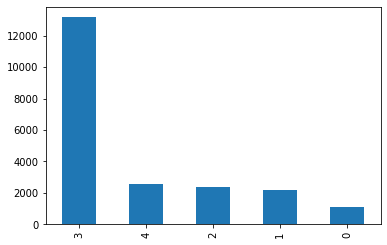

In [10]:
import torch.optim as optim
from sklearn.model_selection import KFold
from torch.utils.data.dataset import Subset

index = 3
name = f"run-{index}"
notes = ""

data_path = os.path.join(config.base_input_path, "train.csv")
data_img_dir_path = os.path.join(config.base_input_path, "train_images")
df = pd.read_csv(train_path)

df.label.value_counts().plot(kind="bar")

In [11]:
def set_seed(seed):
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    os.environ["PYTHONHASHSEED"] = str(seed)
    return random_state

set_seed(42)

RandomState(MT19937) at 0x7FB042DDFC00

In [12]:

k_fold = KFold(n_splits=2)
train_dataset = CassavaDataset(
    annotation_path=data_path,
    img_dir_path=data_img_dir_path,
    img_transforms=transforms.Compose([
        transforms.ToTensor(),    
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
)
val_dataset = CassavaDataset(
    annotation_path=data_path,
    img_dir_path=data_img_dir_path,
    img_transforms=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
)

for fold, (train_index, val_index) in enumerate(k_fold.split(df)):
    train_subset = Subset(train_dataset, train_index)
    train_dataloader = DataLoader(
        train_subset,
        batch_size=config.batch_size,
        num_workers=config.num_workers,
        shuffle=True,
    )
    val_subset = Subset(val_dataset, val_index)
    val_dataloader = DataLoader(
        val_subset,
        batch_size=config.batch_size,
        num_workers=config.num_workers,
    )
    model = CassavaNetwork()
    model = model.to(torch.device("cuda"))
    model = nn.DataParallel(model)

    optimizer = optim.Adam(model.parameters(), lr=config.lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    loss_function = nn.CrossEntropyLoss()

    activate_function = nn.Softmax(dim=1)

    trainer = Trainer(
        model,
        optimizer,
        scheduler,
        loss_function,
        train_dataloader,
    )
    classifier = Classifier(
        model,
        activate_function,
        train_dataloader,
        phase="train",
        phase_input=ClassifierTrainInput(),
    )

    val_classifier = Classifier(
        model,
        activate_function,
        val_dataloader,
        phase="test",
        phase_input=ClassifierTestInput(),
    )


    for epoch in tqdm(range(config.n_epochs)):
        epoch += 1
        train_out = trainer.advance()
        print(f"epoch: {epoch}, train loss: {train_out.loss}")
#         train_infer_out = classifier.infer()
#         print(f"epoch: {epoch}, train acc: {train_infer_out.acc}")
#         val_infer_out = val_classifier.infer()
#         print(f"epoch: {epoch}, val acc: {val_infer_out.acc}")
    break

# Create submissions


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  3%|▎         | 1/30 [04:35<2:13:16, 275.73s/it]

epoch: 1, train loss: 0.7587166458723091



  7%|▋         | 2/30 [08:39<1:59:59, 257.12s/it]

epoch: 2, train loss: 0.514705495820159



 10%|█         | 3/30 [12:41<1:52:26, 249.89s/it]

epoch: 3, train loss: 0.44320091374573256



 13%|█▎        | 4/30 [16:41<1:46:35, 246.00s/it]

epoch: 4, train loss: 0.40005073758463067



 17%|█▋        | 5/30 [20:41<1:41:34, 243.80s/it]

epoch: 5, train loss: 0.3494082115191434



 20%|██        | 6/30 [24:39<1:36:47, 242.00s/it]

epoch: 6, train loss: 0.32896692571895464



 23%|██▎       | 7/30 [28:43<1:32:57, 242.48s/it]

epoch: 7, train loss: 0.294957880019432



 27%|██▋       | 8/30 [32:49<1:29:19, 243.62s/it]

epoch: 8, train loss: 0.26320837650980267



 30%|███       | 9/30 [36:49<1:24:54, 242.60s/it]

epoch: 9, train loss: 0.2248956933174105



 33%|███▎      | 10/30 [40:54<1:21:04, 243.24s/it]

epoch: 10, train loss: 0.19691395493490355



 37%|███▋      | 11/30 [44:52<1:16:30, 241.61s/it]

epoch: 11, train loss: 0.1652887605485462



 40%|████      | 12/30 [48:54<1:12:31, 241.78s/it]

epoch: 12, train loss: 0.13961580887969052



 43%|████▎     | 13/30 [52:53<1:08:17, 241.02s/it]

epoch: 13, train loss: 0.12115805922076106



 47%|████▋     | 14/30 [56:55<1:04:23, 241.46s/it]

epoch: 14, train loss: 0.10517137653992645



 50%|█████     | 15/30 [1:00:56<1:00:18, 241.25s/it]

epoch: 15, train loss: 0.09734517660745907



 53%|█████▎    | 16/30 [1:04:57<56:15, 241.09s/it]  

epoch: 16, train loss: 0.07942572114102188



 57%|█████▋    | 17/30 [1:08:57<52:08, 240.69s/it]

epoch: 17, train loss: 0.06406116047097991



 60%|██████    | 18/30 [1:12:53<47:54, 239.51s/it]

epoch: 18, train loss: 0.055472280054042734



 63%|██████▎   | 19/30 [1:16:56<44:03, 240.35s/it]

epoch: 19, train loss: 0.0456964805489406



 67%|██████▋   | 20/30 [1:20:51<39:47, 238.75s/it]

epoch: 20, train loss: 0.042430459488449354



 70%|███████   | 21/30 [1:24:49<35:47, 238.63s/it]

epoch: 21, train loss: 0.033810823648569306



 73%|███████▎  | 22/30 [1:28:46<31:45, 238.22s/it]

epoch: 22, train loss: 0.028737394408034606



 77%|███████▋  | 23/30 [1:32:45<27:47, 238.21s/it]

epoch: 23, train loss: 0.025712825953849546



 80%|████████  | 24/30 [1:36:47<23:56, 239.39s/it]

epoch: 24, train loss: 0.021527968685231394



 83%|████████▎ | 25/30 [1:40:48<20:00, 240.05s/it]

epoch: 25, train loss: 0.020747705559534507



 87%|████████▋ | 26/30 [1:44:51<16:03, 240.96s/it]

epoch: 26, train loss: 0.025778546336195654



 90%|█████████ | 27/30 [1:48:58<12:07, 242.52s/it]

epoch: 27, train loss: 0.023137383484503345



 93%|█████████▎| 28/30 [1:53:01<08:05, 242.83s/it]

epoch: 28, train loss: 0.014550640147977642



 97%|█████████▋| 29/30 [1:57:01<04:01, 241.91s/it]

epoch: 29, train loss: 0.012531123207216817



100%|██████████| 30/30 [2:01:02<00:00, 242.08s/it]

epoch: 30, train loss: 0.00979959165089808


## Submission

In [13]:
test_data_path = os.path.join(config.base_input_path, "sample_submission.csv")
test_data_img_dir_path = os.path.join(config.base_input_path, "test_images")
test_dataset = CassavaDataset(
    annotation_path=test_data_path,
    img_dir_path=test_data_img_dir_path,
    img_transforms=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    num_workers=config.num_workers,
)

test_classifier = Classifier(
    model,
    activate_function,
    test_dataloader,
    phase="test",
    phase_input=ClassifierTrainInput(),
)

out = test_classifier.infer()
out.df.to_csv("submission.csv", index=False)

100%|██████████| 1/1 [00:00<00:00,  1.71it/s]
